In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import math

In [1]:
def sim_seasonal(series_len, seasonality, duration=1, scale=.05, seed=None, seeded=False):
    """ get seasonal effects that sum to 0 over seasonal period"""
    
    if seeded:
        np.random.seed(seed)

    seas = []
    iterations = math.ceil(series_len / duration)
    init_seas = np.zeros(seasonality)

    init_seas[:-1] = np.random.normal(
        0, scale, seasonality - 1
    )

    init_seas[seasonality - 1] = -1 * np.sum(init_seas)
    for idx in range(iterations):
        seas += [init_seas[idx % seasonality]] * duration
    seas = np.array(seas[:series_len])
    
    return seas

### Local Linear Trend

In [2]:
def local_level_seasonal(num_timesteps, init_level=1, 
                        obs_scale = 1, level_scale=.1,
                        seasonal_scale=1, seasonality=12, 
                        stochastic_seasonal=True,
                        seasonality_scale = .05,
                        seeded=False, seed=None):

    if seeded:
        np.random.seed(seed)
    
    level = np.zeros(num_timesteps+1)
    y = np.zeros(num_timesteps)

    # Get seasonal effects
    seasonal = sim_seasonal(num_timesteps, seasonality, scale=seasonal_scale, seed=seed, seeded=seeded)

    level[0] = init_level

    for t in range(num_timesteps):
        level[t+1] = level[t] + np.random.normal(0, scale=level_scale)
        y[t] = level[t] + seasonal[t] + np.random.normal(loc=0, scale=obs_scale)

    fig, ax = plt.subplots(2, figsize=(7,8))
    ax[0].plot(y, label='emissions', color='k', alpha=.6)
    ax[0].plot(level, label = 'level', color='darkorange')
    ax[1].plot(seasonal, label='seasonal', color="b")
    fig.legend()

In [6]:

def local_level_trend_seasonal(num_timesteps, init_level=1, init_slope=.5, 
                               obs_scale = 1, slope_scale = .01, level_scale=1, seasonal_scale=1, 
                               seasonality=12, stochastic_seasonal=False, seasonality_scale = .05,
                               seeded=False, seed=None):

    level = np.zeros(num_timesteps+1)
    slope= np.zeros(num_timesteps+1)
    y = np.zeros(num_timesteps)

    if seeded:
        np.random.seed(seed)

    # Get seasonal effects
    seasonal = sim_seasonal(num_timesteps, seasonality, 1, seasonal_scale, seeded=seeded, seed=seed)

    slope[0] = init_slope
    level[0] = init_level

    for t in range(num_timesteps):
        level[t+1] = level[t] + slope[t] + np.random.normal(0, scale=level_scale)
        slope[t+1] = slope[t] + np.random.normal(0, scale=slope_scale)
        if stochastic_seasonal:
            seasonal[t] = seasonal[t] + np.random.normal(loc=0, scale=seasonality_scale)
        y[t] = level[t] + seasonal[t] + np.random.normal(loc=0, scale=obs_scale)

    fig, ax = plt.subplots(3, figsize=(7,8))
    ax[0].plot(y, label='emissions', color='k', alpha=.6)
    ax[0].plot(level, label = 'level', color='darkorange')
    ax[1].plot(slope, label="slope", color='k')
    ax[2].plot(seasonal, label="seasonal", color="b")
    fig.legend()

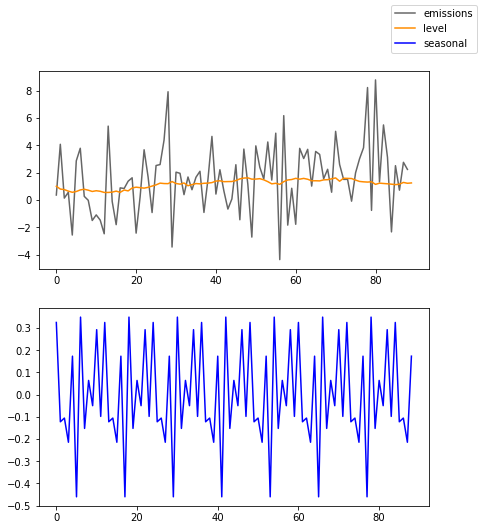

In [9]:
local_level_seasonal(89, obs_scale=3, seasonal_scale=.2, stochastic_seasonal=True, seeded=True, seed=1)

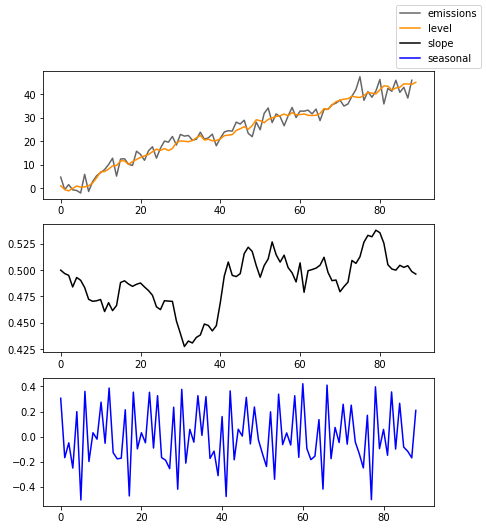

In [7]:
local_level_trend_seasonal(89, obs_scale=3, seasonal_scale=.2, stochastic_seasonal=True, seeded=True, seed=1)

### Static Intervention

In [ ]:
T = 200

intervention_length = int(T*.2)
intervention_start = T - intervention_length

# Create States + Obs 
level = np.zeros(T+1)
slope = np.zeros(T+1)
y = np.zeros(T)
intervention_weights = np.zeros(T+1)

init_slope = .5 
init_level = 1 
init_weight = -20

# Set Initial Values
slope[0] = init_slope
level[0] = init_level
intervention_weights[intervention_start] = -50

# Provide Scales
obs_scale = 10
slope_scale = .01
level_v_scale = .01
intervention_scale = 1

for t in range(T):
    level[t+1] = level[t] + slope[t] + np.random.normal(0, scale=level_v_scale)
    slope[t+1] = slope[t] + np.random.normal(0, scale=slope_scale)
    if t >= intervention_start:
        y[t] = level[t] + intervention_weights[t] + np.random.normal(loc=0, scale=obs_scale)
        intervention_weights[t+1] = intervention_weights[t] + np.random.normal(loc=0, scale=intervention_scale) 
    else:
        y[t] = level[t] + np.random.normal(loc=0, scale=obs_scale)

fig, ax = plt.subplots(3, figsize=(10,6))
ax[0].plot(y, alpha=1, label="emissions", color='k', )
ax[1].plot(intervention_weights, alpha=1, label="intervention weight")
ax[2].plot(slope, label="slope")
fig.legend()

### Rising Intervention

### Setting Intervention Effect as % of Y

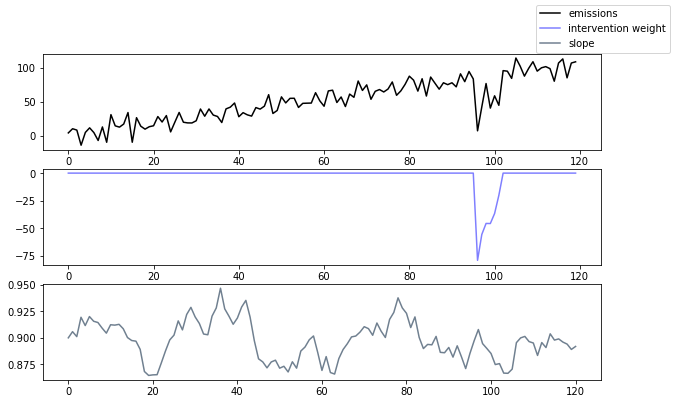

In [96]:
T = 120

intervention_length = 6
intervention_start = int(T*.8)

weight_multiplier = .9

# Create States + Obs 
level = np.zeros(T+1)
slope = np.zeros(T+1)
y = np.zeros(T)
intervention_weights = np.zeros(T)

# Init values
init_slope = .9
init_level = 1 

# Set Initial Values
slope[0] = init_slope
level[0] = init_level

# Error Term Scales
obs_scale = 10
slope_scale = .01
level_v_scale = .01
intervention_scale = 10

### Simulate without intervention Effect
for t in range(T):
    level[t+1] = level[t] + slope[t] + np.random.normal(0, scale=level_v_scale)
    slope[t+1] = slope[t] + np.random.normal(0, scale=slope_scale)
    y[t] = level[t] + np.random.normal(loc=0, scale=obs_scale)

### Set intervention effect as a percentage of the value at t=intervention_start
init_weight = y[intervention_start] * -weight_multiplier
step = abs(init_weight / (intervention_length))
intervention_weights[intervention_start:intervention_start+intervention_length] = np.arange(start=init_weight, stop=0, step=step)
intervention_weights

### Add weights back to observed y values
for t in range(intervention_start,intervention_start+intervention_length):
    intervention_weights[t] = intervention_weights[t] + np.random.normal(loc=0, scale=intervention_scale)
    y[t] = level[t] + intervention_weights[t] + np.random.normal(loc=0, scale=obs_scale)

### Plot
fig, ax = plt.subplots(3, figsize=(10,6))
ax[0].plot(y, alpha=1, label="emissions", color='k')
ax[1].plot(intervention_weights, color='b', alpha=.5, label="intervention weight")
ax[2].plot(slope, label="slope", color='slategrey')
fig.legend()